In [1]:
%matplotlib nbagg

import os
import time
import logging

import numpy as np
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [3]:
import qcodes.instrument_drivers.tektronix.AWG5014 as awg  # <--- The instrument driver
from qcodes.instrument_drivers.tektronix.AWGFileParser import parse_awg_file  # <--- A helper function

awg1 = awg.Tektronix_AWG5014('AWG1', 'TCPIP::169.254.106.135::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5204 (serial:B020214, firmware:FV:6.0.0243.0) in 0.22s


In [ ]:
# Note: if you have had any initialisation problems, the VISA message queue of the instrument could be fouled up
#(e.g. if the cell above gave you back something like 'Connected to: 1.20000000E+009 ...')
# in that case, run the following command to reset the message queue
awg1.clear_message_queue()

In [4]:
print(awg1.ch3_state.get())
print(awg1.ch2_offset.get())
awg1.ch2_offset.set(0.1)
print(awg1.ch2_offset.get())

0
0.0
0.1


In [5]:
pars = np.sort(list(awg1.parameters.keys()))
for param in pars:
    print(param, ': ', awg1.parameters[param].label)

DC_output :  DC Output (ON/OFF)
IDN :  IDN
ch1_DC_out :  DC output level channel 1
ch1_add_input :  Add input channel {}
ch1_amp :  Amplitude channel 1
ch1_direct_output :  Direct output channel 1
ch1_filter :  Low pass filter channel 1
ch1_m1_del :  Channel 1 Marker 1 delay
ch1_m1_high :  Channel 1 Marker 1 high level
ch1_m1_low :  Channel 1 Marker 1 low level
ch1_m2_del :  Channel 1 Marker 2 delay
ch1_m2_high :  Channel 1 Marker 2 high level
ch1_m2_low :  Channel 1 Marker 2 low level
ch1_offset :  Offset channel 1
ch1_state :  Status channel 1
ch1_waveform :  Waveform channel 1
ch2_DC_out :  DC output level channel 2
ch2_add_input :  Add input channel {}
ch2_amp :  Amplitude channel 2
ch2_direct_output :  Direct output channel 2
ch2_filter :  Low pass filter channel 2
ch2_m1_del :  Channel 2 Marker 1 delay
ch2_m1_high :  Channel 2 Marker 1 high level
ch2_m1_low :  Channel 2 Marker 1 low level
ch2_m2_del :  Channel 2 Marker 2 delay
ch2_m2_high :  Channel 2 Marker 2 high level
ch2_m2_l

In [13]:
noofseqelems = 6
noofpoints = 1200
waveforms = [[], []]  # one list for each channel
m1s = [[], []]
m2s = [[], []]
for ii in range(noofseqelems):
    # waveform and markers for channel 1
    waveforms[0].append(np.sin(np.pi*(ii+1)*np.linspace(0, 1, noofpoints))*np.hanning(noofpoints))
    m1 = np.zeros(noofpoints)
    m1[:int(noofpoints/(ii+1))] = 1
    m1s[0].append(m1)
    print(len(m1s))
    m2 = np.zeros(noofpoints)
    m2s[0].append(m2)

    # waveform and markers for channel two
    wf = np.sin(np.pi*(ii+1)*np.linspace(0, 1, noofpoints))
    wf *= np.arctan(np.linspace(-20, 20, noofpoints))/np.pi*2
    waveforms[1].append(wf)
    m1 = np.zeros(noofpoints)
    m1[:int(noofpoints/(ii+1))] = 1
    m1s[1].append(m1)
    m2 = np.zeros(noofpoints)
    m2s[1].append(m2)

2
2
2
2
2
2


<IPython.core.display.Javascript object>


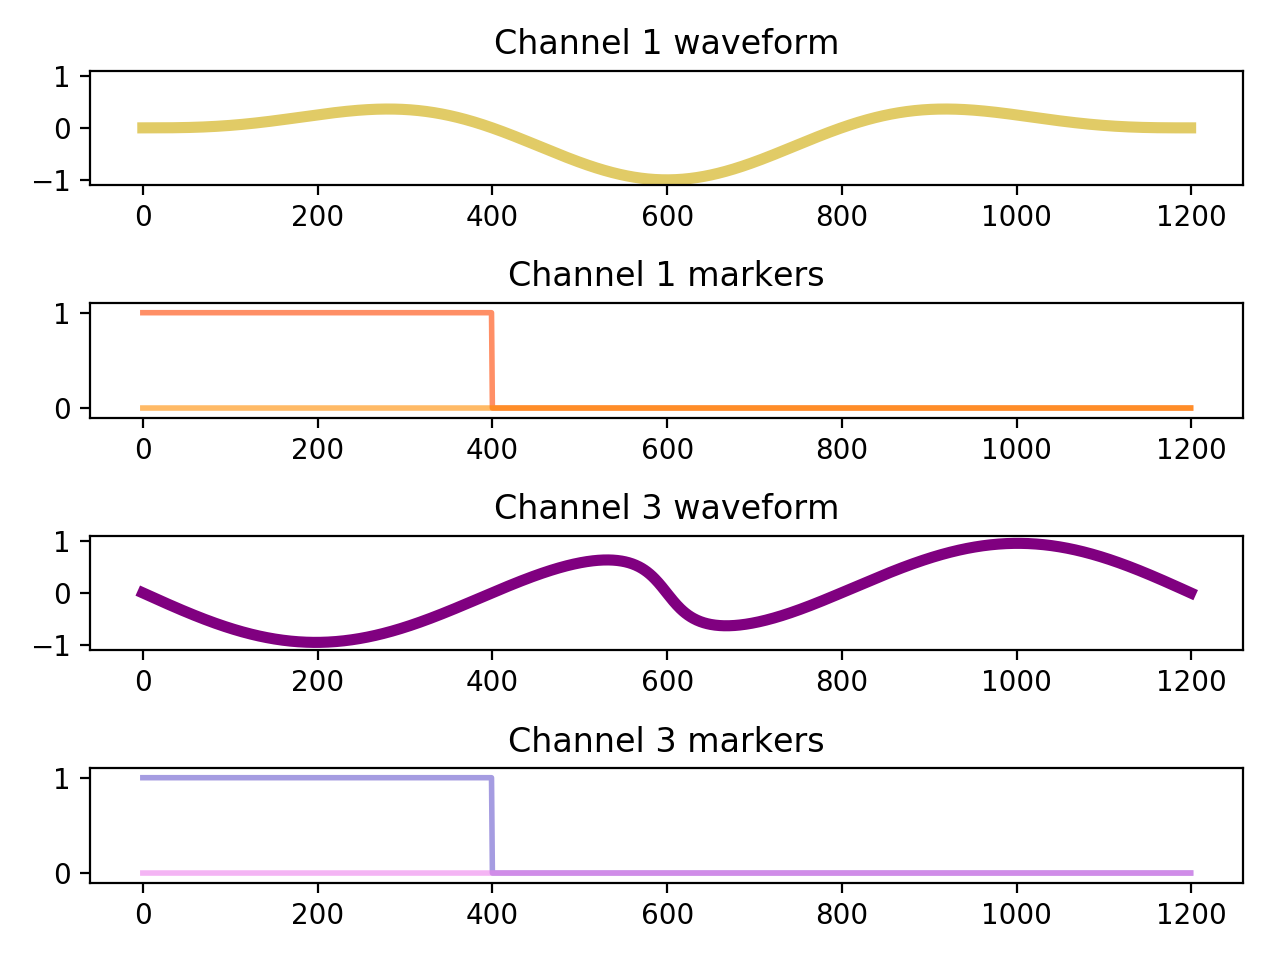

In [7]:
# We can visualise the waveforms and markers
fig = plt.figure()

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
ax1.set_title('Channel 1 waveform')
ax1.set_ylim([-1.1, 1.1])
ax2.set_title('Channel 1 markers')
ax2.set_ylim([-0.1, 1.1])
ax3.set_title('Channel 3 waveform')
ax3.set_ylim([-1.1, 1.1])
ax4.set_title('Channel 3 markers')
ax4.set_ylim([-0.1, 1.1])

elemnum = 2  # choose which element to plot
ax1.plot(waveforms[0][elemnum], lw=4, color='#e1cb66')
ax2.plot(m1s[0][elemnum], lw=2, color='#FF4500', alpha=0.6)
ax2.plot(m2s[0][elemnum], lw=2, color='#FF8C00', alpha=0.6)
ax3.plot(waveforms[1][elemnum], lw=4, color='#800080')
ax4.plot(m1s[1][elemnum], lw=2, color='#6A5ACD', alpha=0.6)
ax4.plot(m2s[1][elemnum], lw=2, color='#EE82EE', alpha=0.6)

plt.tight_layout()

In [8]:
# Sequencing options

# number of repetitions
nreps = [2 for ii in range(noofseqelems)]
# Wait trigger (0 or 1)
trig_waits = [0]*noofseqelems
# Goto state
goto_states = [((ii+1) % noofseqelems)+1 for ii in range(noofseqelems)]
#goto_states = [0]*noofseqelems
# Event jump
jump_tos = [2]*noofseqelems

In [ ]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s,
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=[1, 3])

In [ ]:
filepath = os.path.join(os.getcwd(), 'test_awg_file.awg')
awgfile = awg1.make_and_save_awg_file(waveforms, m1s, m2s, nreps, trig_waits, goto_states,
                                      jump_tos, channels=[1, 3], filename=filepath)

In [ ]:
(callsig, instdict) = parse_awg_file(filepath)
(waveforms, m1s, m2s, nreps, trig_waits, goto_states, jump_tos, channels) = callsig

In [ ]:
awg1.make_send_and_load_awg_file(waveforms, m1s, m2s,
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=channels)

In [ ]:
# First clear up the waveform list and empty the sequencer
awg1.delete_all_waveforms_from_list()
# Then set the sequence length to the correct number lest not all sequence elements get uploaded
awg1.sequence_length.set(noofseqelems)

In [ ]:
#Then transfer the waveforms to the list...
for elnum in range(noofseqelems):
    for chnum in range(2):
        wfmname = 'wfm{:03d}ch{}'.format(elnum, chnum+1)
        awg1.send_waveform_to_list(waveforms[chnum][elnum], m1s[chnum][elnum], m2s[chnum][elnum], wfmname)
#...upload them to the sequencer...
for elnum in range(noofseqelems):
    for chnum in range(2):
        wfmname = 'wfm{:03d}ch{}'.format(elnum, chnum+1)
        awg1.set_sqel_waveform(wfmname, chnum+1, elnum+1)
#...and set the sequence elements setting
for elnum in range(noofseqelems):
    awg1.set_sqel_goto_target_index(elnum+1, goto_states[elnum])
    awg1.set_sqel_loopcnt(nreps[elnum], elnum+1)
    awg1.set_sqel_trigger_wait(elnum+1, trig_waits[elnum])
    awg1.set_sqel_event_target_index(elnum+1, jump_tos[elnum])

In [ ]:
from time import sleep

# Set the corresponding sequencing options
for seq_elem in range(1, awg1.sequence_length.get()+1):
    awg1.set_sqel_loopcnt_to_inf(seq_elem, state=1)

In [ ]:
# Now jump around in a "lazy" way
awg1.run()
awg1.sequence_pos.set(1)
sleep(2)
awg1.sequence_pos.set(3)
sleep(1)
awg1.sequence_pos.set(2)
sleep(3)
awg1.stop()

In [ ]:
# number of repetitions
nreps = [0 for ii in range(noofseqelems)]  # Infinite repetitions

# It doesn't matter what we set the next values to, but the lists need to exist and have the right length

# Wait trigger (0 or 1)
trig_waits = [0]*noofseqelems
# Goto state
goto_states = [0]*noofseqelems
# Event jump
jump_tos = [0]*noofseqelems

awg1.make_send_and_load_awg_file(waveforms, m1s, m2s,
                                 nreps, trig_waits,
                                 goto_states, jump_tos, channels=[1, 3])

In [ ]:
awg1.close()